In [136]:
%pip install pycaret

Note: you may need to restart the kernel to use updated packages.


In [137]:
%pip install mlflow==2.7.1

Note: you may need to restart the kernel to use updated packages.


In [138]:
import sys, os
from pathlib import Path

# 1) Obtener la ruta al directorio del proyecto (un nivel arriba de notebooks/)
project_root = Path().resolve().parent

# 2a) Opción A: que Python vea "src" como paquete:
sys.path.insert(0, str(project_root))

# 2b) Opción B (más directo), apuntar directamente a src/, y usar import desde eda:
# sys.path.insert(0, str(project_root / "src"))

print("PYTHONPATH:", sys.path[:3])

PYTHONPATH: ['C:\\Users\\leona\\source\\repos\\fau_predic_salario', 'C:\\Users\\leona\\source\\repos\\fau_predic_salario', 'C:\\Users\\leona\\source\\repos\\fau_predic_salario']


In [139]:
import pandas as pd
from src.eda.eda import merge_multiple_dataframes
#Feature Engineering
from src.feature.feature import build_pipeline

#Configuración de parametros de Pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib') 
pd.options.mode.chained_assignment = None

# En produccion eliminar, se incluye por informacion
print(f'Pandas Version: {pd.__version__}') 

Pandas Version: 2.1.4


In [140]:
# Cargar los datos
file_paths = ['../data/descriptions.csv', '../data/people.csv', '../data/salary.csv']
df_merged = merge_multiple_dataframes(file_paths, 'id')

In [141]:
from pycaret.regression import * 

In [142]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   375 non-null    int64  
 1   Description          372 non-null    object 
 2   Age                  370 non-null    float64
 3   Gender               370 non-null    object 
 4   Education Level      370 non-null    object 
 5   Job Title            370 non-null    object 
 6   Years of Experience  373 non-null    float64
 7   Salary               373 non-null    float64
dtypes: float64(3), int64(1), object(4)
memory usage: 23.6+ KB


In [143]:
df_merged = df_merged.dropna()

In [144]:
# # Inicialize pipeline
# full_pipeline = build_pipeline()

# # Fit only on training data
# df_merged_transformed = full_pipeline.fit_transform(df_merged)

# df_merged_final = full_pipeline.transform(df_merged)

In [145]:
df_merged.head()

,id,Description,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,0,"I am a 32-year-old male working as a Software Engineer with a Bachelor's degree in Computer Science. With five years of experience, I specialize in designing, developing, and maintaining software applications. My expertise includes programming languages such as Python, Java, and C++, and I am proficient in Agile and DevOps methodologies. I have worked on diverse projects, from web applications to backend systems, and take pride in writing clean, maintainable code. I thrive in collaborative team environments and am committed to continuous learning and professional growth.",32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,1,"I am a 28-year-old data analyst with a Master's degree and three years of experience in the field. My role involves collecting, processing, and analyzing large datasets to support informed decision-making within my organization. I excel at uncovering hidden patterns and insights, and I present my findings clearly and actionably. I collaborate with various departments, continuously learning and contributing to the company's success. I am committed to staying updated with the latest trends and technologies in data analytics through continuous professional development.",28.0,Female,Master's,Data Analyst,3.0,65000.0
2,2,"I am a 45-year-old Senior Manager with a PhD and 15 years of extensive experience in my field. My advanced education has equipped me with deep industry knowledge and research capabilities. In my role, I oversee projects, mentor junior staff, and ensure strategic goals are met. I excel in navigating complex challenges and delivering exceptional results. Committed to continuous learning, I stay updated with the latest industry trends to maintain a competitive edge. My passion for excellence and drive to achieve have been key factors in my professional growth and success.",45.0,Male,PhD,Senior Manager,15.0,150000.0
3,3,"I am a 36-year-old female Sales Associate with a Bachelor's degree and seven years of experience in the field. My expertise lies in customer service, sales techniques, and product knowledge, which have been instrumental in my success. I excel in connecting with customers, understanding their needs, and providing tailored solutions. My commitment to continuous improvement and staying updated with industry trends drives my professional growth. I am dedicated to exceeding expectations and contributing to the success of my team and organization.",36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,4,"I am a 52-year-old male with over two decades of experience in my field, currently serving as a Director. Holding a Master's degree, I have developed a deep understanding of the industry, enabling me to lead teams effectively and make strategic decisions. My role involves overseeing various aspects of the organization, from strategic planning to operational execution, and collaborating with different departments to ensure our objectives are met. I take pride in mentoring my team and fostering an environment of collaboration and innovation, continuously striving to drive organizational success.",52.0,Male,Master's,Director,20.0,200000.0


In [159]:
import pandas as pd
import numpy as np
from sklearn.pipeline         import Pipeline
from sklearn.compose          import ColumnTransformer
from sklearn.preprocessing    import OrdinalEncoder, OneHotEncoder, StandardScaler

from src.feature.feature import FeatureEngineer, create_preprocessor

df = df_merged.copy()
original_cols = [
    c for c in df.columns 
    if c != 'Job Title' and c != 'Gender'
]

# 2) Define un preprocessor que devuelva DataFrame en lugar de ndarray
def create_preprocessor_df() -> ColumnTransformer:
    ct = ColumnTransformer(
        transformers=[
            ("ord_edu",
             OrdinalEncoder(categories=[["Bachelor's","Master's","PhD"]]),
             ["Education Level"]),
            ("ohe",
             OneHotEncoder(handle_unknown="ignore", sparse_output=False),
             ["Gender","Seniority","Role_family"]),
            ("scale",
             StandardScaler(),
             ["Age","Years of Experience","Exp_education"]),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    )
    return ct.set_output(transform="pandas")

# 3) Monta el pipeline usando este preprocessor
pipeline = Pipeline([
    ("feat",   FeatureEngineer()),      # crea Seniority, Role_family, Exp_education y quita Job Title
    ("pre",    create_preprocessor_df()),
])

X = pipeline.fit_transform(df)

if isinstance(X, np.ndarray):
    # pull the names out of the ColumnTransformer
    ct = pipeline.named_steps['pre']  # or 'preproc' if that's your step name
    cols = ct.get_feature_names_out()
    df_trans = pd.DataFrame(X, columns=cols, index=df.index)
else:
    df_trans = X

# 3) Now you can split base vs. extras safely
base   = original_cols.copy()
extras = [c for c in df_trans.columns if c not in base]

# 4) And finally re-order
df_final = df_trans[ base + extras ]

# 5) Verify
print(df_final.shape)
print(df_final.columns.tolist())
df_final.head()


(358, 24)
['id', 'Description', 'Age', 'Education Level', 'Years of Experience', 'Salary', 'Gender_Female', 'Gender_Male', 'Seniority_Director', 'Seniority_Junior', 'Seniority_Lead', 'Seniority_Mid', 'Seniority_Senior', 'Role_family_Analytics', 'Role_family_Data', 'Role_family_Design', 'Role_family_Engineering', 'Role_family_Finance', 'Role_family_HR', 'Role_family_Marketing', 'Role_family_Other', 'Role_family_Product', 'Role_family_Sales', 'Exp_education']


,id,Description,Age,Education Level,Years of Experience,Salary,Gender_Female,Gender_Male,Seniority_Director,Seniority_Junior,...,Role_family_Data,Role_family_Design,Role_family_Engineering,Role_family_Finance,Role_family_HR,Role_family_Marketing,Role_family_Other,Role_family_Product,Role_family_Sales,Exp_education
0,0,"I am a 32-year-old male working as a Software Engineer with a Bachelor's degree in Computer Science. With five years of experience, I specialize in designing, developing, and maintaining software applications. My expertise includes programming languages such as Python, Java, and C++, and I am proficient in Agile and DevOps methodologies. I have worked on diverse projects, from web applications to backend systems, and take pride in writing clean, maintainable code. I thrive in collaborative team environments and am committed to continuous learning and professional growth.",-0.769,0.0,-0.770,90000.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.752
1,1,"I am a 28-year-old data analyst with a Master's degree and three years of experience in the field. My role involves collecting, processing, and analyzing large datasets to support informed decision-making within my organization. I excel at uncovering hidden patterns and insights, and I present my findings clearly and actionably. I collaborate with various departments, continuously learning and contributing to the company's success. I am committed to staying updated with the latest trends and technologies in data analytics through continuous professional development.",-1.334,1.0,-1.074,65000.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.696
2,2,"I am a 45-year-old Senior Manager with a PhD and 15 years of extensive experience in my field. My advanced education has equipped me with deep industry knowledge and research capabilities. In my role, I oversee projects, mentor junior staff, and ensure strategic goals are met. I excel in navigating complex challenges and delivering exceptional results. Committed to continuous learning, I stay updated with the latest industry trends to maintain a competitive edge. My passion for excellence and drive to achieve have been key factors in my professional growth and success.",1.067,2.0,0.750,150000.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.498
3,3,"I am a 36-year-old female Sales Associate with a Bachelor's degree and seven years of experience in the field. My expertise lies in customer service, sales techniques, and product knowledge, which have been instrumental in my success. I excel in connecting with customers, understanding their needs, and providing tailored solutions. My commitment to continuous improvement and staying updated with industry trends drives my professional growth. I am dedicated to exceeding expectations and contributing to the success of my team and organization.",-0.204,0.0,-0.466,60000.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.640
4,4,"I am a 52-year-old male with over two decades of experience in my field, currently serving as a Director. Holding a Master's degree, I have developed a deep understanding of the industry, enabling me to lead teams effectively and make strategic decisions. My role involves overseeing various aspects of the organization, from strategic planning to operational execution, and collaborating with different departments to ensure our objectives are met. I take pride in mentoring my team and fostering an environment of collaboration and innovation, continuously striving to drive organizational success.",2.055,1.0,1.510,200000.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.217


In [160]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 358 entries, 0 to 374
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       358 non-null    int64  
 1   Description              358 non-null    object 
 2   Age                      358 non-null    float64
 3   Education Level          358 non-null    float64
 4   Years of Experience      358 non-null    float64
 5   Salary                   358 non-null    float64
 6   Gender_Female            358 non-null    float64
 7   Gender_Male              358 non-null    float64
 8   Seniority_Director       358 non-null    float64
 9   Seniority_Junior         358 non-null    float64
 10  Seniority_Lead           358 non-null    float64
 11  Seniority_Mid            358 non-null    float64
 12  Seniority_Senior         358 non-null    float64
 13  Role_family_Analytics    358 non-null    float64
 14  Role_family_Data         358 no

In [161]:
df_final.drop(columns=['id'], inplace=True)
df_final.drop(columns=['Description'], inplace=True)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 358 entries, 0 to 374
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      358 non-null    float64
 1   Education Level          358 non-null    float64
 2   Years of Experience      358 non-null    float64
 3   Salary                   358 non-null    float64
 4   Gender_Female            358 non-null    float64
 5   Gender_Male              358 non-null    float64
 6   Seniority_Director       358 non-null    float64
 7   Seniority_Junior         358 non-null    float64
 8   Seniority_Lead           358 non-null    float64
 9   Seniority_Mid            358 non-null    float64
 10  Seniority_Senior         358 non-null    float64
 11  Role_family_Analytics    358 non-null    float64
 12  Role_family_Data         358 non-null    float64
 13  Role_family_Design       358 non-null    float64
 14  Role_family_Engineering  358 no

In [ ]:
#%pip show pycaret

Name: pycaret
Version: 3.3.2
Summary: PyCaret - An open source, low-code machine learning library in Python.
Home-page: https://github.com/pycaret/pycaret
Author: Moez Ali
Author-email: moez.ali@queensu.ca
License: MIT
Location: c:\users\leona\anaconda3\envs\funda_apre_auto\lib\site-packages
Requires: category-encoders, cloudpickle, deprecation, imbalanced-learn, importlib-metadata, ipython, ipywidgets, jinja2, joblib, kaleido, lightgbm, markupsafe, matplotlib, nbformat, numba, numpy, pandas, plotly, plotly-resampler, pmdarima, psutil, pyod, requests, schemdraw, scikit-learn, scikit-plot, scipy, sktime, statsmodels, tbats, tqdm, xxhash, yellowbrick
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [162]:
colIgnore = ['Description']

In [ ]:
#colCateg = ['Gender','Job Title', 'Education Level']

In [163]:
exp_1002 = setup(data = df_final,target='Salary',ignore_features= colIgnore,
                 normalize = True, log_experiment=True, experiment_name='Salary_1002',
                 session_id = 1002)

,Description,Value
0,Session id,1002
1,Target,Salary
2,Target type,Regression
3,Original data shape,"(358, 22)"
4,Transformed data shape,"(358, 22)"
5,Transformed train set shape,"(250, 22)"
6,Transformed test set shape,"(108, 22)"
7,Ignore features,1
8,Numeric features,21
9,Preprocess,True


In [165]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,7924.8120,172345367.7763,12451.7283,0.9246,0.2810,0.4776,0.1050
lightgbm,Light Gradient Boosting Machine,8982.1005,188777445.4938,13302.3431,0.9168,0.2098,0.5216,0.5170
rf,Random Forest Regressor,8719.7254,197040037.0659,13473.8969,0.9124,0.2236,0.4914,0.0880
gbr,Gradient Boosting Regressor,8980.5396,201238215.0682,13660.4884,0.9114,0.2232,0.5241,0.0290
huber,Huber Regressor,9910.4852,239544869.4417,14364.5544,0.9001,0.2231,0.5960,0.0150
br,Bayesian Ridge,10439.4902,238359168.0000,14653.5874,0.8993,0.2334,0.6224,0.0360
ridge,Ridge Regression,10489.1218,240065375.2000,14733.3905,0.8983,0.2350,0.6148,0.0150
llar,Lasso Least Angle Regression,10515.1256,240853526.4000,14763.8896,0.8980,0.2339,0.6123,0.0220
lr,Linear Regression,10546.1260,242115194.4000,14808.9097,0.8974,0.2360,0.6117,0.0250
lasso,Lasso Regression,10544.9043,242107177.6000,14808.0451,0.8974,0.2360,0.6118,0.0230


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [166]:
et_model = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6737.9100,121672875.2025,11030.5428,0.9395,0.1040,0.0694
1,5882.0000,76769100.0000,8761.7978,0.9592,0.1041,0.0670
2,8115.8500,111351429.4514,10552.3187,0.9351,0.1082,0.0847
3,11027.1500,233303391.3958,15274.2722,0.8613,0.1322,0.1004
4,5171.0000,44795525.0000,6692.9459,0.9788,0.0838,0.0642
5,9571.0000,464344625.0000,21548.6572,0.8458,0.1556,0.0756
6,6915.3333,121760722.2222,11034.5241,0.9499,0.1235,0.0750
7,6868.0000,115761600.0000,10759.2565,0.9575,0.9236,4.0112
8,8040.0000,132305400.0000,11502.4084,0.9564,0.9268,0.1193


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [169]:
tuned_et_model = tune_model(et_model, n_iter=50, optimize='R2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7501.5596,141797373.3126,11907.8702,0.9295,0.1063,0.0751
1,5372.7221,51694653.7975,7189.8994,0.9726,0.0965,0.0622
2,9233.2751,170082671.3411,13041.5747,0.9009,0.1223,0.0929
3,10110.0903,200276114.7347,14151.8944,0.8809,0.1066,0.0852
4,7210.0473,84431130.6742,9188.6414,0.9600,0.1280,0.0981
5,11124.8311,506901217.9030,22514.4669,0.8317,0.1657,0.0980
6,6586.7568,94069781.6084,9698.9578,0.9613,0.1071,0.0715
7,9627.1681,162477971.7009,12746.6847,0.9403,0.9483,4.4907
8,10099.8424,185178842.2506,13608.0433,0.9390,0.1471,0.1207


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [170]:
plot_model(et_model, plot = 'parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
criterion,squared_error
max_depth,None
max_features,1.0
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,1
min_samples_split,2


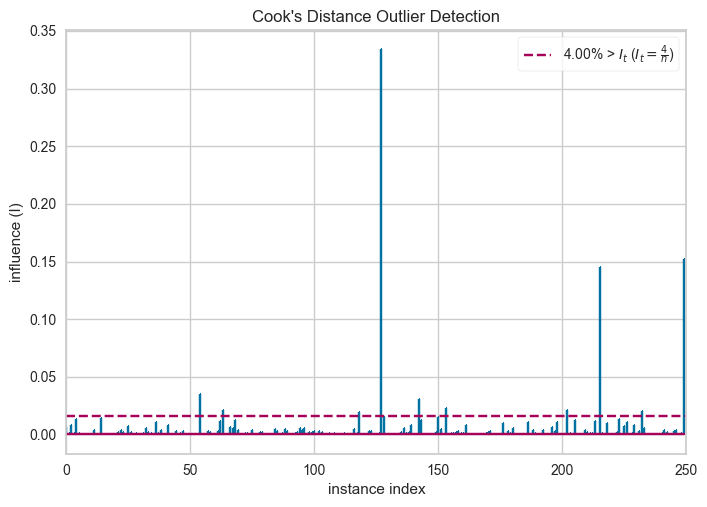

In [171]:
plot_model(et_model, plot = 'cooks')

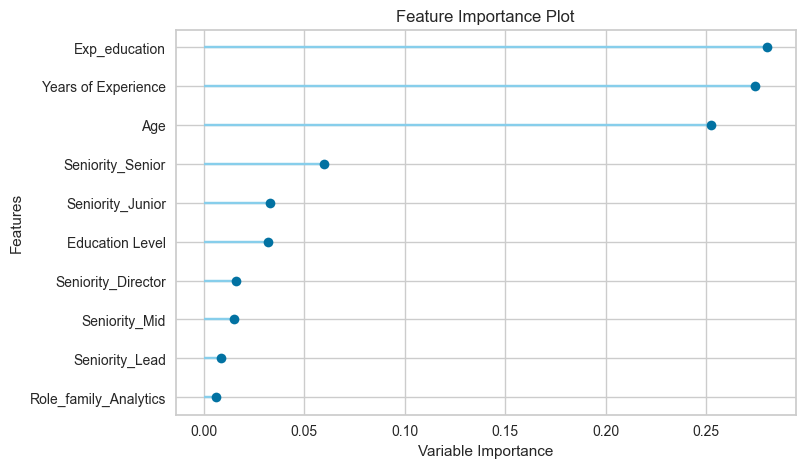

In [172]:
plot_model(et_model, plot = 'feature')

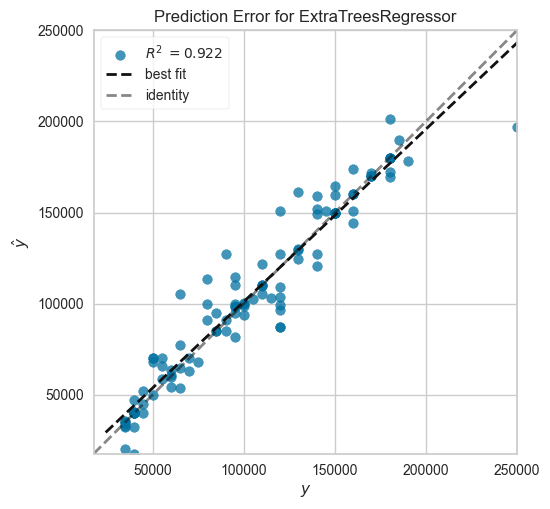

In [173]:
plot_model(et_model, plot = 'error')

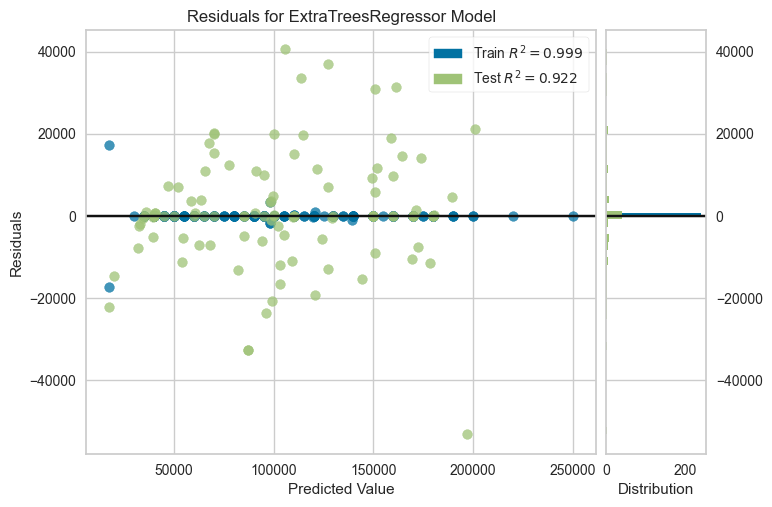

In [174]:
plot_model(et_model)

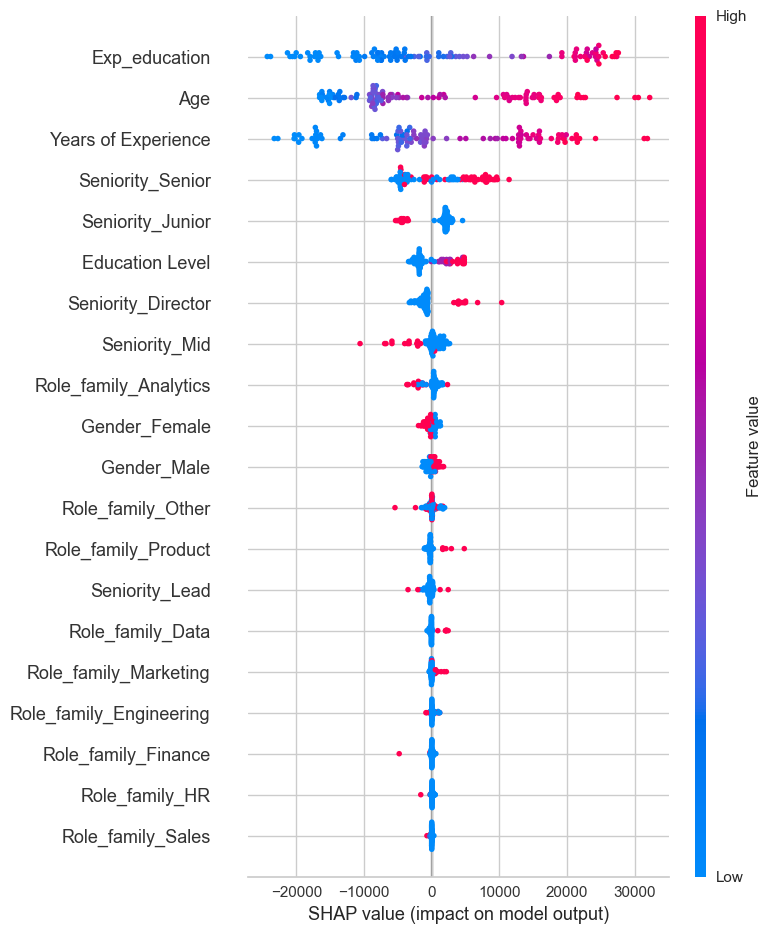

In [175]:
interpret_model(et_model)

In [176]:
predict_model(et_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,8589.1535,184629911.7319,13587.8590,0.9223,0.1631,0.0973


,Age,Education Level,Years of Experience,Gender_Female,Gender_Male,Seniority_Director,Seniority_Junior,Seniority_Lead,Seniority_Mid,Seniority_Senior,...,Role_family_Engineering,Role_family_Finance,Role_family_HR,Role_family_Marketing,Role_family_Other,Role_family_Product,Role_family_Sales,Exp_education,Salary,prediction_label
167,1.208,2.0,1.206,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.004,150000.0,159650.0
83,2.055,2.0,2.118,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.017,250000.0,196700.0
249,1.349,1.0,1.510,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.217,170000.0,171500.0
295,-0.628,0.0,-0.922,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.808,60000.0,60000.0
11,1.490,0.0,1.206,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.021,140000.0,120650.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,-1.758,0.0,-1.530,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.033,35000.0,34400.0
202,0.925,0.0,0.902,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.133,130000.0,124250.0
302,0.078,0.0,-0.162,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.527,120000.0,87400.0
268,-0.628,0.0,-0.922,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.808,60000.0,60800.0


In [177]:
final_et_model = finalize_model(et_model)

In [178]:
predict_model(final_et_model)

,Age,Education Level,Years of Experience,Gender_Female,Gender_Male,Seniority_Director,Seniority_Junior,Seniority_Lead,Seniority_Mid,Seniority_Senior,...,Role_family_Engineering,Role_family_Finance,Role_family_HR,Role_family_Marketing,Role_family_Other,Role_family_Product,Role_family_Sales,Exp_education,Salary,prediction_label
167,1.208,2.0,1.206,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.004,150000.0,152600.0
83,2.055,2.0,2.118,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.017,250000.0,248300.0
249,1.349,1.0,1.510,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.217,170000.0,172700.0
295,-0.628,0.0,-0.922,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.808,60000.0,62450.0
11,1.490,0.0,1.206,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.021,140000.0,140900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,-1.758,0.0,-1.530,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.033,35000.0,37950.0
202,0.925,0.0,0.902,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.133,130000.0,128950.0
302,0.078,0.0,-0.162,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.527,120000.0,110400.0
268,-0.628,0.0,-0.922,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.808,60000.0,62800.0


In [179]:
save_model(final_et_model,'../model/20250517_final_et_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Age', 'Education Level',
                                              'Years of Experience',
                                              'Gender_Female', 'Gender_Male',
                                              'Seniority_Director',
                                              'Seniority_Junior',
                                              'Seniority_Lead', 'Seniority_Mid',
                                              'Seniority_Senior',
                                              'Role_family_Analytics',
                                              'Role_family_Data',
                                              'Role_family_Design',
                                              'Role_family_Engineering',
                                              '...
                                              'Exp_education'],
                            